In [ ]:
%pylab inline

import pandas as pd
%load_ext autoreload
%autoreload 2
import pysfg

# Static Spectra Analysis

## Quartz or Gold Spectrum for Normalization

The idear of the analysis is to seperate some distinkt properties of the data analysis. the `static_spectra.py` script contains the typical logic of what one want to do with static spectral data. For each usecase, a new `some_name.yaml` file needs to be passed to the `static_spectra.py` file, to configure a specific set of data. What it basically does is:

- read of data files
- calibrate pixels to wavenumbers 
- trim data (pixels and spectrum index)
- take median of scans and pp_delays
- save result in a structured `.json` file

The syntax for using `static_spectra.py` is:

```
python static_spectra.py path_to_config.yaml
```

or from within the notebook:
```
%run static_spectra.py path_to_config.yaml
```


`yaml` files are a structured way of storing information or in this case configuration. [Here](https://rollout.io/blog/yaml-tutorial-everything-you-need-get-started/) is a possible tutorial explaining many aspects of yaml. Understanding yaml is not very difficult. If you are confused by `simple_gold.yaml` take a peak at the mentioned tutorial. In short, indentation matters, `:` seperates `key:value` just like python dicts, lists can be given with`[1, 2, 3]`  or

``` yaml
- 1
- 2
- 3 
```

numbers are read as `float` or `int`, text is read as `string`

Lets go through the structure of `simple_gold.yaml` for now:

``` yaml
calibration:
    vis_wl: 799.7 # Wavelength of the visible
    calib_central_wl: 680 # central wavelength during calibration
    calib_coeff: [0.080881, 615.18] # calibration coefficients from calibration
```

This block shows how to apply a calibration. This `calibration:` block is read by the `static_spectra.py` script and used for calibration. If it doesn't exist, `static_spectra.py` tries to read the information of the data file. Take a look at `static_spectra.py` within you find the following block:

``` python
    calibration_config = config.get('calibration', {})
    calibration = pysfg.Calibration(
        calibration_config.get('central_wl', intensity_data['central_wl']),
        calibration_config.get('vis_wl', intensity_data['vis_wl']),
        calibration_config.get('calib_central_wl', intensity_data['calib_central_wl']),
        calibration_config.get('calib_coeff', intensity_data['calib_coeff'])
    )
```
This block is mostly responsible for the above begaviour. `config` is the python respresentation of the complete `simple_gold.yaml` file. Within `config` a `calibration` key is searched and if not found, and empty dict is passed. Then within the `calibration` dict, `central_wl`, `vis_wl`, `calib_central_wl` and `calib_coeff` is used and if not found the infomration is read of the `intensity_data` dict, that represents the content of the `intensity_data` file, including the header.

This calibration is then followed by a `data:` block. This block is mandatory and it consists out of an arbitraty amount of `-` seperated blocks. Each of these blocks is configuring a single spectrum by referencing it to its respective `intensity_data:`, `baseline_data:` and `norm_data:`. However only the `intensity_data:` and `name:` is mandatory. The rest is optional.
   
``` yaml
data:
  -
    # Path to a data file that contains raw intensity data.
    intensity_data:  "../tests/data/gold.dat"
    # Configure selection of data. E.g. pixels, pp_delays, spectra or scans.
    intensity_selector:
      # The index of the spectrum that should be used.
      spectra: 1
    # Path to a data file that contains raw background data.
    background_data: "../tests/data/gold_bg.dat" # Relative to fpath
    background_selector:
      spectra: 1
      #pixel: Has no function here, as it is Overwritten by the intensity_selector pixels.
    name: "cache/gold_1.json"
```

The key `intensity_data` is mapped to a filepath with a *victor* or *vivian* `.dat` data file and the path is relative to the position of this notebook you are looking at right now. The `intensity_selector` is optional and can have up to four sub keys: `pp_delays`, `scans`, `spectra` and `pixel`. For static spectra `spectra` and `pixel` are the most important.  As they are used to trim down the data into a relevant section. `spectra: 1` means take only spectrum 1. Internally a `pysfg.SelectorPP` object is created from this block. The `background_data`  and `background_selector` then works identical but is taking care of the background intensity. `name` is the path to a `.json` file, where the strucutred result of the `static_spectra.py` script is saved as a `json` file. This file can then be used for visualizing and further processing of the spectrum. For educational purpose the full data block is:


```yaml
data:
  -
    # Path to a data file that contains raw intensity data.
    intensity_data:  "../tests/data/gold.dat"
    # Configure selection of data. E.g. pixels, pp_delays, spectra or scans.
    intensity_selector:
      # The index of the spectrum that should be used.
      spectra: 1
    # Path to a data file that contains raw background data.
    background_data: "../tests/data/gold_bg.dat" # Relative to fpath
    background_selector:
      spectra: 1
      #pixel: Has no function here, as it is Overwritten by the intensity_selector pixels.
    name: "cache/gold_1.json"
  # You can have as many of these blocks as you want
  -
    intensity_data:  "../tests/data/gold.dat"
    intensity_selector:
      spectra: 0 # Lets use some other spectrum of the same data file
      pixel: [520, 810] # A list in [start, stop, step] order
      scans: [0, 3] # use onlay the first three scans.
      pp_delays: null # This is the same as not putting it at all
    background_data: "../tests/data/gold_bg.dat"
    background_selector:
      spectra: 0
    name: "cache/gold_2.json"

```
Where a second `-` block is added. It shows some more possible options and how this script can be used to process arbitrary amount of spectra. Just append another `-` block and configure it to your liking. 

Now lets see how to actually run this. Execute:

In [ ]:
%run static_spectra.py simple_gold.yaml

The log above gives you some information on what is happending. It tels you the path of the importet data, the calibration configuartion and the path where the result is exportet.

Next step is to visualize the result. The following is a possible example of what you could do now:

In [ ]:
# Import the json files and create a pysfg.Spectrum object from them in one go.
norm = pysfg.spectrum.json_to_spectrum('cache/gold_1.json')
norm2 = pysfg.spectrum.json_to_spectrum('cache/gold_2.json')

# Select some pixels for visualization
pixel=[460, 810]
# Figures
fig, ax = plt.subplots()
plt.plot(norm.wavenumber[slice(*pixel)], norm.basesubed[slice(*pixel)])
plt.xlabel('Frequency/cm$^{-1}$')
plt.ylabel('Counts')
plt.title('Normalization')

# Figures
fig, ax = plt.subplots()
plt.plot(norm2.wavenumber, norm2.basesubed)
plt.xlabel('Frequency/cm$^{-1}$')
plt.ylabel('Counts')
plt.title('Normalization')

In the example above, the calibration is manually passed within the `simple_gold.yaml` file in the `calibration:` section. This is needed, because the read file `../tests/data/gold.dat` contains no correct calibration data. Just open the file and check out the `# calib Coeff=0` line. This is not a correct calibration. The file `../tests/data/sc_quartz.dat` contains a correct calibration. Checkout the file header. It reads: `# calib Coeff=670	642.101	0.034274	0	0	0	0` 

`simple_quartz.yaml` shows you a configuration that reads the information of the file itself.

In [ ]:
%run static_spectra.py simple_quartz.yaml

Again import and visualize

In [ ]:
norm = pysfg.spectrum.json_to_spectrum('cache/quartz_1.json')
pixel=slice(None)

# Figures
fig, ax = plt.subplots()
plt.plot(norm.wavenumber[pixel], norm.basesubed[pixel])
plt.xlabel('Frequency/cm$^{-1}$')
plt.ylabel('Counts')
plt.title('Normalization')

I highly encourage you to use this import/export sceme as you see here. Initially it is some overhead, but in time you will realize, that it seperates logic (analysis) from plotting (visualizing) and it will make your live way easier if you start preparing presentations, or papers or what ever, you want to be ablte to quickly change the visualization but not the logic. This sheme allows you to do so.

## Normalize a Static Spectrum

To normalize some static spectra, you can use the same template script `static_spectra.py`. However you have to change the specific configuration of course.

In [ ]:
%run static_spectra.py simple_spectrum.yaml

Now `simple_spectrum.yaml` contains:
    
```yaml
data:
  -
    intensity_data:  "../tests/data/sc_d2o-dopc.dat"
    intensity_selector:
      spectra: 1
      # you can pass all kwargs of pysfg.SelectorPP here. Thus also:
      pixel: [200, 1200]
      # scans: [start, stop, step]
      # pp_delays: [start, stop, step]
    background_data: "../tests/data/bg_d2o-docpe.dat"
    background_selector:
      spectra: 1
    # Norm data must be the result of a prior static_spectra.py run.
    norm_data: "./cache/quartz_1.json"
    name: "cache/sc_d2o-dopc_static.json"
```

Basically everything is indentical to the quartz or gold case as we have seen above, but note the `norm_data` line. Here we give it a path to one of the previously exported `quartz_1.json` files, as we want to use this for normalization. There is no `norm_selector` keyword available, if you want to change the normalization, go to the `simple_quarty.yaml` file, add or change one of the blocks in `data:` and reference the result here.

Now lets visualize the result:

In [ ]:
sc = pysfg.spectrum.json_to_spectrum('cache/sc_d2o-dopc_static.json')

# Figures
fig, ax = plt.subplots()
plt.plot(sc.wavenumber, sc.basesubed)
plt.xlabel('Frequency/cm$^{-1}$')
plt.ylabel('Counts')
plt.title('Normalization')

Or if you want to plot the normalized version you do:

In [ ]:
fig, ax = plt.subplots()
plt.plot(sc.wavenumber, sc.normalized)
plt.xlabel('Frequency/cm$^{-1}$')
plt.ylabel('A.u.')
plt.title('Normalization')

Or you can even take a look at the raw data:

In [ ]:
fig, ax = plt.subplots()
plt.plot(sc.pixel, sc.intensity)
plt.xlabel('Pixel')
plt.ylabel('Counts')
plt.title('Normalization')

Note how the pixels start at 200 and not at 0, as we have configured it that way in `simple_spectrum.yaml` by passing it `pixel: [200, 1200]`. If you want, you can also create a pandas Dataframe from the result of `simple_spectrum.py` Just do the following:

In [ ]:
pd.read_json('./cache/sc_d2o-dopc_static.json')

# Time Series Data

In [14]:
pysfg.read.victor.data_file('../tests/data/dynamic_test_data.dat')

{'Scan Start time': '24.08.2018  01:10:44',
 'Scan Stop time': '24.08.2018  13:07:07',
 'Gain': '1',
 'Output Amplifier': 'Conventional Amp',
 'HS_Speed [MHz]': '0.05',
 'ExposureTime [s]': '100',
 'HBin': 'ON',
 'Central-Wavelength': '680',
 'vis-Wavelength': '749',
 'Syringe Pos': '37',
 'Timefile': 'C:\\Labview\\Timefiles\\test-6.txt',
 'Timedelay': '-10000\t-7000\t-2000\t-1000\t-750\t-500\t-250\t-100\t-50\t0\t50\t100\t150\t200\t300\t400\t450\t500\t600\t700\t800\t1000\t1250\t1500\t1750\t2000\t2500\t3000\t4000\t5000\t7500\t10000\t15000\t20000\t30000',
 'Timedelay Pos': '97\t97\t98\t98\t98\t98\t98\t98\t98\t98\t98\t98\t98\t98\t98\t98\t98\t98\t98\t98\t98\t98\t98\t98\t98\t98\t99\t99\t99\t99\t99\t100\t100\t101\t103',
 'Cursor': '290\t250\t135\t95\t45\t5',
 'x-mirror': 'OFF',
 'calib Coeff': (0.0,),
 'gain': '1',
 'exposure_time': datetime.timedelta(seconds=100),
 'hbin': False,
 'central_wl': 680.0,
 'vis_wl': 749.0,
 'syringe_pos': 37,
 'cursor': (290, 250, 135, 95, 45, 5),
 'x_mirror': 

In [46]:
%run timescan.py timescan.yaml

INFO:root:Importing: ../tests/data/dynamic_test_data.dat
INFO:root:Using data_select is:
[slice(None, None, None), slice(None, None, None), 0, slice(520, 810, None)]
INFO:root:Using Calibration with:
Central Wavelength: 680.0
Visible Wavelength: 799.7
Calibration Coefficients: (0.080881, 615.18)
Calibration Central Wavelength: 680.0

/home/malte/Projects/pysfg/templates/timescan.py:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  intensity_data['data'][intensity_selector.select],
/home/malte/Projects/pysfg/templates/timescan.py:47: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result eit

In [40]:
pumped = pysfg.spectrum.json_to_pumpprobe('./cache/pumped.json')
probed = pysfg.spectrum.json_to_pumpprobe('./cache/probed.json')

In [64]:
%run bleach.py bleach.yaml

INFO:root:Run difference mode
INFO:root:Saving to: ./cache/bleach.json


<Figure size 432x288 with 0 Axes>

In [62]:
bleach = pysfg.spectrum.json_to_bleach('./cache/bleach.json')

<function matplotlib.pyplot.show(*args, **kw)>

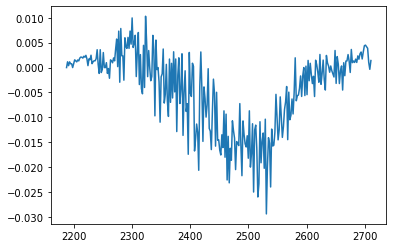

In [63]:
fig, ax = plt.subplots()
plt.plot(bleach.wavenumber, bleach.normalized[13])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

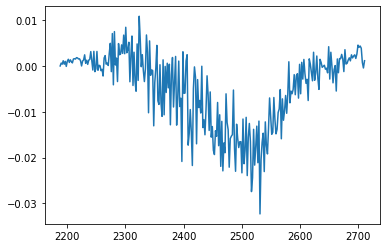

In [60]:
fig, ax = plt.subplots()
plt.plot(bleach.wavenumber, bleach.normalized[13])
plt.show